# <span style='color:blue'> 1. Création du fichier json issu de l'api de l'Atlas de Zones Inondables</span>

https://api.gouv.fr/les-api/api-georisques
https://api.gouv.fr/documentation/api-georisques

## Importation des librairies et lecture du fichier des codes INSEE avec en face les codes régions et départements ainsi que les coordonnées géographiques (geo_shape).
https://public.opendatasoft.com/explore/dataset/correspondance-code-insee-code-postal/export/

In [1]:
import pandas as pd
import requests
import json
import time

debut = time.time()

DATAPATH="./data/"

dfInsee = pd.read_csv(DATAPATH+'correspondance-code-insee-code-postal.csv', sep=";")

## 1.1. Problème: La récupération des données à la volée à partir du fichier principal prend trop de temps et doit s'exécuter à chaque fois.

In [2]:
# limitInsee à choisir (nb insee : 36742 - temps:  )
#limitInsee=100
limitInsee=len(listInsee)
listAziData = list()

NameError: name 'listInsee' is not defined

## 1.2. Solution: La requête s'exécute une seule fois par lot de 10 pour l'enregistrer dans un fichier json.

In [ ]:
li=0
starticodeinsee=2-2
#starticodeinsee=36731-2 # idx = ligne xls -2 pour code 32383
for i in range(starticodeinsee,len(listInsee),10):
    if i <= limitInsee:
        #print(listInsee[i])
        urlinsee=""
        for j in range(1,10,1):
            k=i+j-1
            if k > len(listInsee) -1:
                break
            else:
                urlinsee=urlinsee + listInsee[k]
                if j < 9 and k < len(listInsee) -1:
                    urlinsee=urlinsee+','

        url = "https://www.georisques.gouv.fr/api/v1/gaspar/azi?code_insee=" + urlinsee + "&rayon=10000"
        li+=1
        print("url", li, ":" , urlinsee)
        dicAzi = json.loads(requests.get(url).text)
        listAziData = listAziData + dicAzi['data']
    else:
        break

#print(len(listAziData))


dfAziData = pd.DataFrame(listAziData)
print(dfAziData.head()['code_insee'])

dfAziData.to_json(DATAPATH+'azidata.json', orient='index')
fin = time.time()

# <span style='color:blue'>2. Création du fichier immo pour récupérer le prix des bâtiments par m2</span>

https://www.data.gouv.fr/fr/reuses/carte-prix-immobilier-carte-dexploration-des-biens-vendus-en-france/
https://files.data.gouv.fr/geo-dvf/latest/csv/2022/full.csv.gz

# 2.1. lecture du fichier d'origine et cleaning en enlevant les ventes qui ne se rapportent pas aux maisons ou aux appartements

In [ ]:
import numpy as np
import pandas as pd
import csv
import time

debut = time.time()

DATAPATH="./data/"

dfImmo = pd.read_csv(DATAPATH+'immo.csv', sep=",")

print(len(dfImmo.axes[0]),'lignes')
# code_type_local = 1 Maison 2 Appartement (type_local)
print(dfImmo[["code_commune", "valeur_fonciere", "code_type_local", "surface_reelle_bati"]].head())
print(dfImmo.columns)

# manip columns
dfImmo.rename(columns={'code_commune':'codeInseeImmo'}, inplace=True)
dfImmo['codeInseeImmo'] = dfImmo.codeInseeImmo.astype('str')
dfImmo['local_total'] = np.where(dfImmo["code_type_local"].isin([1, 2]), 1, 0)
dfImmo['local_maison'] = np.where(dfImmo['code_type_local']== 1, 1, 0)
dfImmo['local_appart'] = np.where(dfImmo["code_type_local"]== 2, 1, 0)
print(dfImmo[["code_type_local", "local_total", "local_maison", "local_appart"]].head())

# manip lignes
dfImmo = dfImmo[dfImmo["code_type_local"].isin([1, 2])]
#print(dfImmo["valeur_fonciere"].isna().value_counts())
#print(dfImmo["surface_reelle_bati"].isna().value_counts())
dfImmo = dfImmo[dfImmo["valeur_fonciere"].notna()]
dfImmo = dfImmo[dfImmo["surface_reelle_bati"].notna()]

## 2.2. Calcul de la valeur mobilière moyenne par code Insee en mettant en face le nombre de maisons et d'appartements s'y rapportant pour le sauvegarder dans un fichier csv.

In [ ]:

#moyenne valeur foncière
dfImmo["valeur_moyenne_fonciere"] = dfImmo["valeur_fonciere"] / dfImmo["surface_reelle_bati"]
print(dfImmo[["codeInseeImmo", "valeur_moyenne_fonciere", "code_type_local"]].head())
print(dfImmo.dtypes)
print(type('codeInseeImmo'))

# new file
#dfImmoNew = dfImmo[["codeInseeImmo", "valeur_moyenne_fonciere", "code_type_local"]]
#dfImmoNew = dfImmo.groupby(['codeInseeImmo'], sort=False, as_index=False )['valeur_moyenne_fonciere'].mean()
dfImmoNew = dfImmo.groupby(['codeInseeImmo'], sort=False, as_index=False ).aggregate({'valeur_moyenne_fonciere':'mean', 'local_total': 'sum', 'local_maison': 'sum', 'local_appart': 'sum' })

# verif
#print(dfImmo[dfImmo["codeInseeImmo"]=='1053']["valeur_moyenne_fonciere"])
#print(dfImmo[dfImmo["codeInseeImmo"]=='1053']["surface_reelle_bati"])
#print(len(dfImmo[dfImmo["codeInseeImmo"]=='1053'].axes[0]))
#print(len(dfImmo[ (dfImmo["codeInseeImmo"]=='1053') & (dfImmo["code_type_local"]==1) ].axes[0]))
#print(len(dfImmo[ (dfImmo["codeInseeImmo"]=='1053') & (dfImmo["code_type_local"]==2) ].axes[0]))
#print(len(dfImmo[dfImmo["code_type_local"]==1].axes[0]))
#print(len(dfImmo[dfImmo["code_type_local"]==2].axes[0]))
#print(len(dfImmo.axes[0]))


# export csv
dfImmoNew['valeur_moyenne_fonciere'] = round(dfImmoNew['valeur_moyenne_fonciere'],0).astype(np.int64)

#dfImmoNew.to_csv(DATAPATH+'immonew.csv', index=False,  float_format="%.f")
dfImmoNew.to_csv(DATAPATH+'immonew.csv', index=False)
fin = time.time()
print('{:.0f}'.format(fin-debut), 'secondes')

# <span style='color:blue'>3. Programme principal de visualisation cartographique des zones insee avec en code couleur la valeur mobilière et des marqueurs pour les zones inondables.</span>

## 3.1. Importation et merge des 3 fichiers insee, azi et immo.

In [1]:
import pandas as pd
#import requests
#import json
#import csv
import folium
import webbrowser
import matplotlib.pyplot as plt
import seaborn as sns
import time

debut = time.time()

DATAPATH="./data/"

#with open(DATAPATH+"correspondance-code-insee-code-postal.csv", "r", encoding="utf-8-sig") as fileInsee:
#    dicInsee = list(csv.DictReader(fileInsee, delimiter=";"))

dfInsee = pd.DataFrame(pd.read_csv(DATAPATH+'correspondance-code-insee-code-postal.csv', sep=";"))
dfImmo = pd.DataFrame(pd.read_csv(DATAPATH+'immonew.csv', sep=","))


#listInsee=[]
#for lineInsee in dfInsee['Code INSEE']:
#    listInsee = listInsee + [ lineInsee ]

listInsee = dfInsee['Code INSEE'].tolist()
#print(type(dfInsee))
#print(dfInsee.head())
#print(dfInsee.columns)
#print(dfInsee['geo_shape'][0])
#print(len(listInsee))

dfAziData = pd.DataFrame(pd.read_json(DATAPATH+'azidata.json', orient='index'))

dfInsee['Code INSEE']=dfInsee['Code INSEE'].astype(str)
dfAziData['code_insee']=dfAziData['code_insee'].astype(str)
dfImmo['codeInseeImmo']=dfImmo['codeInseeImmo'].astype(str)

# how=inner -> left
#dfMergeAzi = pd.merge(dfInsee, dfAziData, left_on="Code INSEE", right_on="code_insee", how='inner').reset_index()
#dfMerge = pd.merge(dfMergeAzi, dfImmo, left_on="Code INSEE", right_on="code_insee", how='iiner').reset_index()
dfMergeAzi = pd.merge(dfInsee, dfAziData, left_on="Code INSEE", right_on="code_insee", how='left', suffixes=(False, False)).reset_index()
dfMerge = pd.merge(dfMergeAzi, dfImmo, left_on="Code INSEE", right_on="codeInseeImmo", how='left', suffixes=(False, False)).reset_index()

#print(dfMerge.head())
print(dfMerge.columns)
#print(dfMerge.shape)

Index(['level_0', 'index', 'Code INSEE', 'Code Postal', 'Commune',
       'Département', 'Région', 'Statut', 'Altitude Moyenne', 'Superficie',
       'Population', 'geo_point_2d', 'geo_shape', 'ID Geofla', 'Code Commune',
       'Code Canton', 'Code Arrondissement', 'Code Département', 'Code Région',
       'code_national_azi', 'libelle_azi', 'liste_libelle_risque',
       'libelle_bassin_risques', 'libelle_commentaire',
       'date_debut_programmation', 'date_fin_programmation',
       'date_debut_etude', 'date_fin_etude', 'date_debut_information',
       'date_fin_information', 'date_realisation', 'date_diffusion',
       'date_publication_web', 'code_insee', 'libelle_commune',
       'codeInseeImmo', 'valeur_moyenne_fonciere', 'local_total',
       'local_maison', 'local_appart'],
      dtype='object')


## 3.2. Récupération des informations sur les risques avec leurs coordonnées géographiques insee pour les marqueurs et calcul des déciles des valeurs mobilières pour les codes couleurs sur la carte.

In [2]:
# Azi

#print(dfMerge["geo_shape"][0])
#print(dfMerge.iloc[0,:])
#dataframe of dataframe

#print(dfMerge.loc[dfMerge['Code Département']=='75','liste_libelle_risque'])
#print(dfMerge['liste_libelle_risque'].head(20))
#print(dfMerge.iloc[6,dfMerge.columns.get_loc('liste_libelle_risque')])
#print(dfMerge.iloc[0,dfMerge.columns.get_loc('liste_libelle_risque')])

#dfMerge['num_risque'] = dfMerge['liste_libelle_risque'].apply(lambda x: ''.join([d['num_risque'] for d in x]))
#dfMerge['num_risque'] = [''.join([d.get('num_risque') for d in x  ]) for x in dfMerge['liste_libelle_risque']]
#dfMerge['libelle_risque_long'] = [''.join([d.get('libelle_risque_long') for d in x]) for x in dfMerge['liste_libelle_risque']]
#dfMerge['num_libelle_risque'] = dfMerge[["num_risque", "libelle_risque_long"]].apply(lambda x: " - ".join(x), axis =1)

dfMerge['num_risque']=""
dfMerge['libelle_risque_long']=""

for i in range(len(dfMerge)):
    #print(dfMerge.iloc[i, dfMerge.columns.get_loc('Code INSEE')])
    #print(dfMerge.iloc[i, dfMerge.columns.get_loc('liste_libelle_risque')])
    #print(type(listeRisque))
    if not isinstance(dfMerge.iloc[i, dfMerge.columns.get_loc('liste_libelle_risque')], float):
        #print("ok",i)
        #print(dfMerge.iloc[i, dfMerge.columns.get_loc('Code INSEE')],listeRisque)

        dfMerge.iloc[i,dfMerge.columns.get_loc('num_risque')]=str((dfMerge.iloc[i,dfMerge.columns.get_loc('liste_libelle_risque')][0])['num_risque'])
        dfMerge.iloc[i,dfMerge.columns.get_loc('libelle_risque_long')]= str((dfMerge.iloc[i,dfMerge.columns.get_loc('liste_libelle_risque')][0])['libelle_risque_long'])

#print(dfMerge.iloc[6,dfMerge.columns.get_loc('liste_libelle_risque')])
#print(dfMerge.iloc[6,dfMerge.columns.get_loc('num_risque')])
#print(dfMerge.iloc[6,dfMerge.columns.get_loc('libelle_risque_long')])

#print(dfMerge["geo_shape"].head())

#print(dfMerge['geo_point_2d'][0])
#print(dfMerge['geo_point_2d'][1])
dfMerge['lat'] = [[d for d in x.split(",")][0] for x in dfMerge['geo_point_2d']]
dfMerge['lon'] = [[d for d in x.split(",")][1] for x in dfMerge['geo_point_2d']]
dfMerge['lat'] = pd.to_numeric(dfMerge['lat'], downcast="float")
dfMerge['lat'] = dfMerge['lat'].astype('float')
dfMerge['lon'] = dfMerge['lon'].astype('float')

#print(type(dfMerge['lat'][0]))
#print(type(dfMerge['lon'][0]))

# Immo

# stockage des deciles des VF dans une liste
listDVF = [0,0,0,0,0,0,0,0,0,0,0]
for i,elementQVF in enumerate(listDVF):
    listDVF[i]=dfMerge["valeur_moyenne_fonciere"].quantile(i/10)
    #print(i,listDVF[i])
print(listDVF)
#print(dfMerge["valeur_moyenne_fonciere"].quantile(0.10))

[0.0, 873.0, 1184.0, 1426.0, 1654.0, 1904.0, 2164.0, 2518.0, 3038.0, 4020.0, 883659.0]


## 3.3. Création de la carte folium et filtrage indispensable par département ou région car afficher toute la france provoque une forte latence dûe à une capacité mémoire insuffisante.
(En cliquant sur les marqueurs, un popup affiche le libellé du rique)

In [3]:
# create a map
m = folium.Map(location=[46.90, 3.05], zoom_start=6)

#print(dfMerge["Code Département"].tolist())

# select dept https://fr.wikipedia.org/wiki/D%C3%A9partement_fran%C3%A7ais
# select region code insee https://fr.wikipedia.org/wiki/R%C3%A9gion_fran%C3%A7aise
dfMerge['Code Département']=dfMerge['Code Département'].astype(str)
dfMerge['Code Région']=dfMerge['Code Région'].astype(str)

# filtre affichage
#dfMergeFilter=dfMerge.copy()
#dfMergeFilter=dfMerge[(dfMerge["Code Département"]=='91')].copy()
#dfMergeFilter=dfMerge[(dfMerge["Code Département"]=='75')].copy()
#dfMergeFilter=dfMerge[(dfMerge["Code Région"]=='31')].copy()
dfMergeFilter=dfMerge[(dfMerge["Code Région"].isin(['31','11']))].copy()
#dfMergeFilter=dfMerge[(dfMerge["Code Région"].str.startswith('5'))].copy()

#reindex et enlever les autres sauvegardés
dfMergeFilter=dfMergeFilter.reset_index(level=None,drop=True).drop('index',axis=1).drop('level_0',axis=1)

#print(dfMergeFilter[["Code Région","Code Département"]].head())


#print(dfMergeFilter.loc[dfMergeFilter.index[0]:dfMergeFilter.index[6],['Code Département','valeur_moyenne_fonciere']])

colorsVF=['#FFFFFF','#085','#13be00','#75e100','#aee500','#dfff00','#fff831','#ffe82f','#ffd500','#ffa51f','#ff7b16']

for i in range(len(dfMergeFilter)):
    #print("geo_shape =",dfMergeFilter["Code INSEE"][i], dfMergeFilter["geo_shape"][i])
    #print("VF=",dfMergeFilter["Code INSEE"][i],dfMergeFilter["valeur_moyenne_fonciere"][i])

    ''' 
    # le paramètre i à l'intérieur de la fonction lambda ne ne fonctionne pas
    folium.GeoJson(dfMergeFilter["geo_shape"][i], style_function=lambda x:{
    'color':'#085'  if dfMergeFilter["valeur_moyenne_fonciere"] [i] <= listDVF[1]
    else '#13be00'  if dfMergeFilter["valeur_moyenne_fonciere"] [i] <= listDVF[2]
    else '#75e100'  if dfMergeFilter[ "valeur_moyenne_fonciere"][i] <= listDVF[3]
    else '#aee500'  if dfMergeFilter[ "valeur_moyenne_fonciere"][i] <= listDVF[4]
    else '#dfff00'  if dfMergeFilter[ "valeur_moyenne_fonciere"][i] <= listDVF[5]
    else '#fff831'  if dfMergeFilter[ "valeur_moyenne_fonciere"][i] <= listDVF[6]
    else '#ffe82f'  if dfMergeFilter[ "valeur_moyenne_fonciere"][i] <= listDVF[7]
    else '#ffd500'  if dfMergeFilter[ "valeur_moyenne_fonciere"][i] <= listDVF[8]
    else '#ffa51f'  if dfMergeFilter[ "valeur_moyenne_fonciere"][i] <= listDVF[9]
    else '#ff7b16'
    #ff0a02 #c80000
    } ).add_to(m)
    '''

    if   dfMergeFilter["valeur_moyenne_fonciere"][i] < listDVF[1]:
        folium.GeoJson(dfMergeFilter["geo_shape"][i], style_function=lambda x:{'color':colorsVF[1]}).add_to(m)
    elif dfMergeFilter["valeur_moyenne_fonciere"][i] < listDVF[2]:
        folium.GeoJson(dfMergeFilter["geo_shape"][i], style_function=lambda x:{'color':colorsVF[2]}).add_to(m)
    elif dfMergeFilter["valeur_moyenne_fonciere"][i] < listDVF[3]:
        folium.GeoJson(dfMergeFilter["geo_shape"][i], style_function=lambda x:{'color':colorsVF[3]}).add_to(m)
    elif dfMergeFilter["valeur_moyenne_fonciere"][i] < listDVF[4]:
        folium.GeoJson(dfMergeFilter["geo_shape"][i], style_function=lambda x:{'color':colorsVF[4]}).add_to(m)
    elif dfMergeFilter["valeur_moyenne_fonciere"][i] < listDVF[5]:
        folium.GeoJson(dfMergeFilter["geo_shape"][i], style_function=lambda x:{'color':colorsVF[5]}).add_to(m)
    elif dfMergeFilter["valeur_moyenne_fonciere"][i] < listDVF[6]:
        folium.GeoJson(dfMergeFilter["geo_shape"][i], style_function=lambda x:{'color':colorsVF[6]}).add_to(m)
    elif dfMergeFilter["valeur_moyenne_fonciere"][i] < listDVF[7]:
        folium.GeoJson(dfMergeFilter["geo_shape"][i], style_function=lambda x:{'color':colorsVF[7]}).add_to(m)
    elif dfMergeFilter["valeur_moyenne_fonciere"][i] < listDVF[8]:
        folium.GeoJson(dfMergeFilter["geo_shape"][i], style_function=lambda x:{'color':colorsVF[8]}).add_to(m)
    elif dfMergeFilter["valeur_moyenne_fonciere"][i] < listDVF[9]:
        folium.GeoJson(dfMergeFilter["geo_shape"][i], style_function=lambda x:{'color':colorsVF[9]}).add_to(m)
    else:
        folium.GeoJson(dfMergeFilter["geo_shape"][i], style_function=lambda x:{'color':colorsVF[10]}).add_to(m)


    lat=float(dfMergeFilter['lat'][i])
    lon = float(dfMergeFilter['lon'][i])
    if not ( isinstance(dfMerge.iloc[i, dfMerge.columns.get_loc('liste_libelle_risque')], float) or dfMergeFilter.loc[i, "num_risque"]=="") :
        #print(dfMergeFilter["num_risque"][i])
        #folium.Marker(location=[lat, lon], popup="<i>" + dfMergeFilter["num_libelle_risque"][i]  + "</i>", tooltip=dfMergeFilter["Commune"][i] ).add_to(m)
        folium.Marker(location=[lat, lon], popup="<i>" + dfMergeFilter["num_risque"][i] + " - " + dfMergeFilter["libelle_risque_long"][i]  + "</i>", tooltip=(dfMergeFilter["Commune"][i] + " - " + str(dfMergeFilter["valeur_moyenne_fonciere"][i]) )   ).add_to(m)

#dfMerge['num_libelle_risque'] = dfMerge[["num_risque", "libelle_risque_long"]].apply(lambda x: " - ".join(x), axis =1)

#save map
m.save('mapInsee.html')
# launch the map
webbrowser.open('mapInsee.html')

True

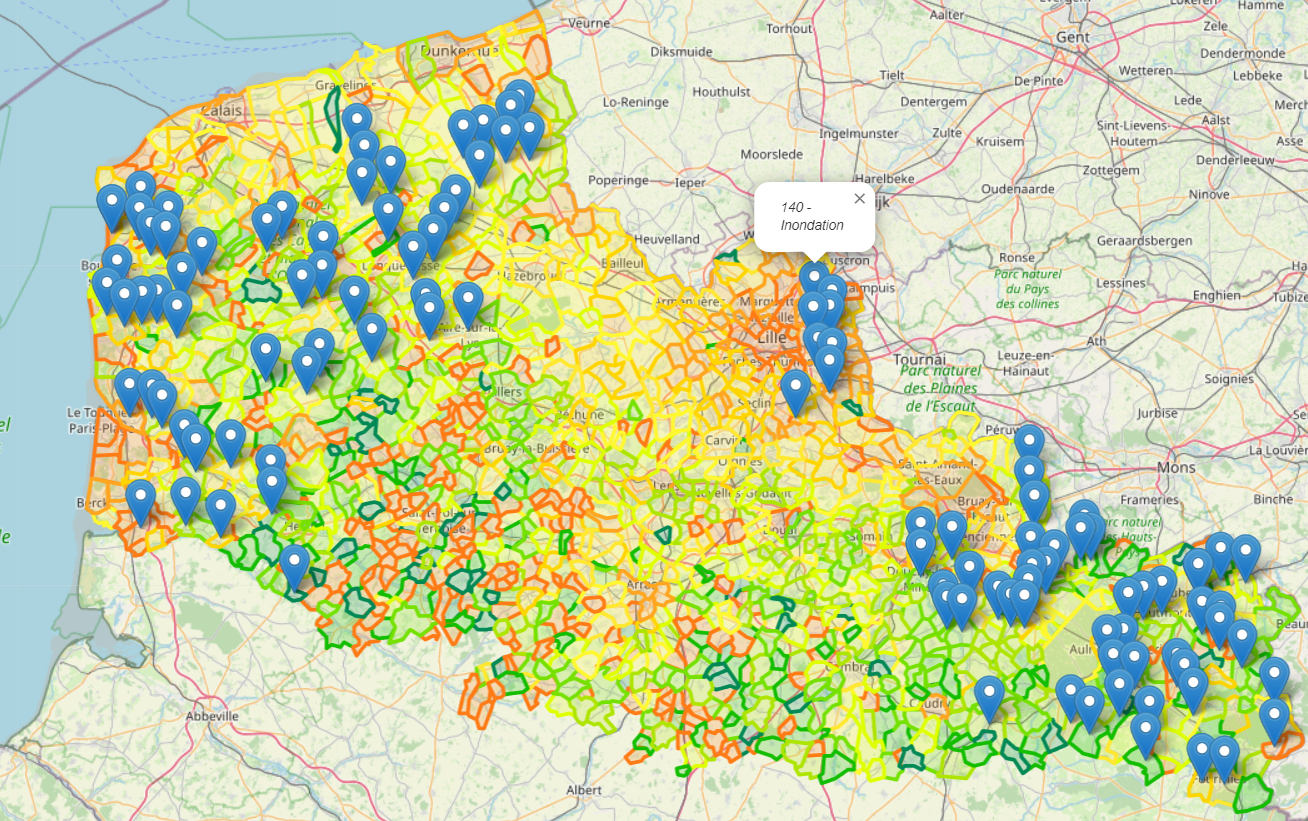

## 3.4. Affichage de charts à partir du dataset filtré

len value libelle_risque_long 3
labelDVF[1:11] ['1 - 873', '874 - 1184', '1185 - 1426', '1427 - 1654', '1655 - 1904', '1905 - 2164', '2165 - 2518', '2519 - 3038', '3039 - 4020', '4021 - ']
countDVF[1:11] [72, 114, 177, 213, 247, 235, 228, 282, 466, 557]


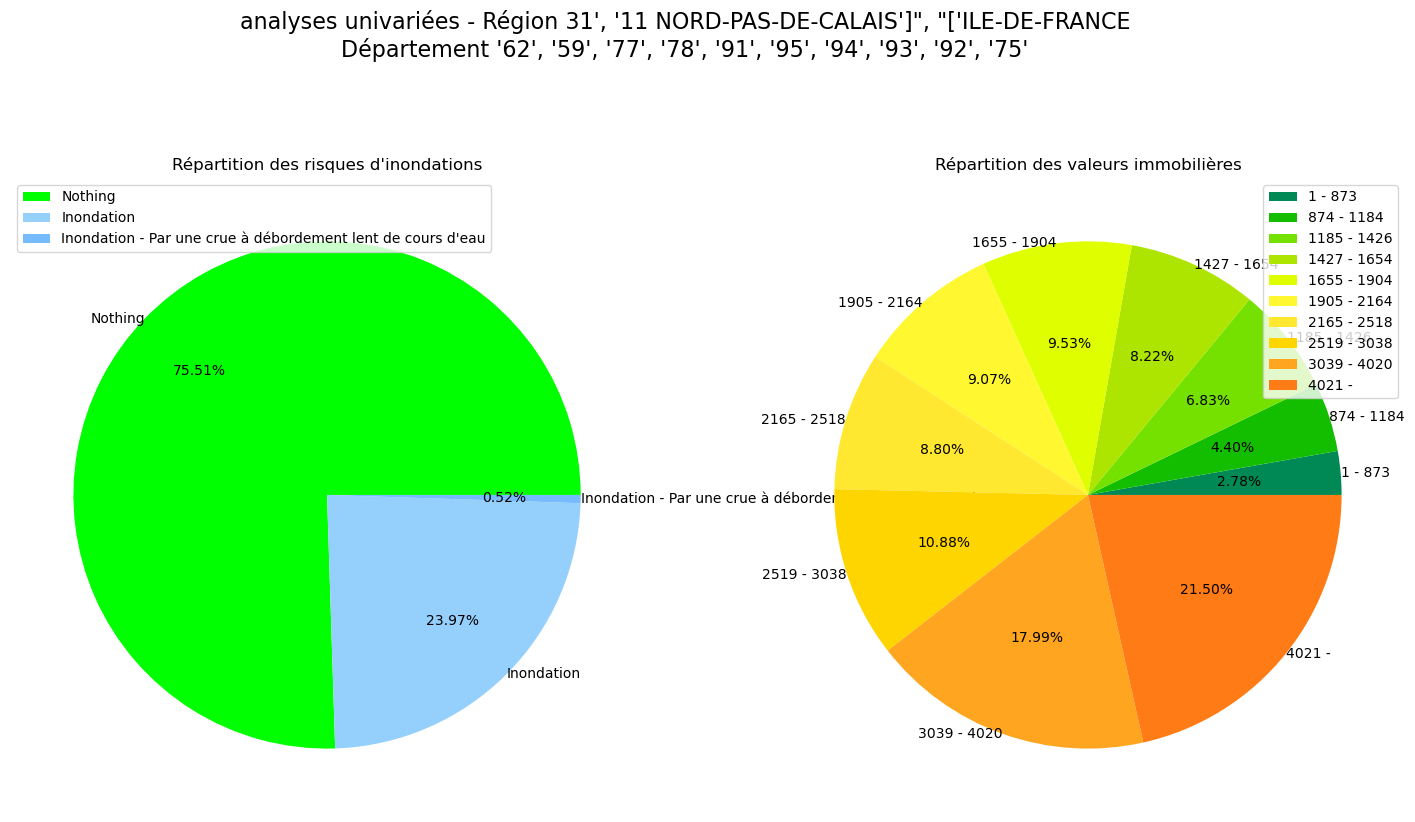

In [4]:
# charts

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(18,10))
fig.suptitle("analyses univariées - Région "+ str(dfMergeFilter["Code Région"].value_counts().index.tolist())[2:-2] + " " + str(dfMergeFilter["Région"].value_counts().index.tolist())[4:-4]
             + "\nDépartement "+ str(dfMergeFilter["Code Département"].value_counts().index.tolist())[1:-1] , fontsize=16)

#print("value num_risque", dfMergeFilter["num_risque"].value_counts())
#print("value libelle_risque_long", dfMergeFilter["libelle_risque_long"].value_counts())
#print("value libelle_risque_long", dfMergeFilter["libelle_risque_long"].value_counts().index.tolist())

print("len value libelle_risque_long",len(dfMergeFilter["libelle_risque_long"].value_counts().index.tolist()))
labelsRisques=['Nothing']
# https://matplotlib.org/stable/api/colors_api.html#module-matplotlib.colors
# https://xkcd.com/color/rgb/
colorsRisques=['lime','xkcd:light blue','xkcd:sky blue','xkcd:cerulean','xkcd:medium blue']
if len(dfMergeFilter["libelle_risque_long"].value_counts().index.tolist())>=2:
    for i in range(1,len(dfMergeFilter["libelle_risque_long"].value_counts().index.tolist())):
        labelsRisques = labelsRisques + [ dfMergeFilter["libelle_risque_long"].value_counts().index.tolist()[i] ]
#print("labelsRisques",labelsRisques)
ax[0].pie(dfMergeFilter["num_risque"].value_counts(), autopct='%1.2f%%', labels=labelsRisques, colors=colorsRisques[0:len(dfMergeFilter["libelle_risque_long"].value_counts().index.tolist())], pctdistance=0.7, labeldistance=1)
ax[0].set_title("Répartition des risques d'inondations")
ax[0].legend(loc="upper left")

countDVF=[0,0,0,0,0,0,0,0,0,0,0]
#print("value VF",dfMergeFilter["valeur_moyenne_fonciere"].value_counts())
countDVF[1] =  len( dfMergeFilter.loc[( dfMergeFilter["valeur_moyenne_fonciere"] <  listDVF[1]) ])
countDVF[2] =  len( dfMergeFilter.loc[( dfMergeFilter["valeur_moyenne_fonciere"] >= listDVF[1]) & (dfMergeFilter["valeur_moyenne_fonciere"] < listDVF[2]) ])
countDVF[3] =  len( dfMergeFilter.loc[( dfMergeFilter["valeur_moyenne_fonciere"] >= listDVF[2]) & (dfMergeFilter["valeur_moyenne_fonciere"] < listDVF[3]) ])
countDVF[4] =  len( dfMergeFilter.loc[( dfMergeFilter["valeur_moyenne_fonciere"] >= listDVF[3]) & (dfMergeFilter["valeur_moyenne_fonciere"] < listDVF[4]) ])
countDVF[5] =  len( dfMergeFilter.loc[( dfMergeFilter["valeur_moyenne_fonciere"] >= listDVF[4]) & (dfMergeFilter["valeur_moyenne_fonciere"] < listDVF[5]) ])
countDVF[6] =  len( dfMergeFilter.loc[( dfMergeFilter["valeur_moyenne_fonciere"] >= listDVF[5]) & (dfMergeFilter["valeur_moyenne_fonciere"] < listDVF[6]) ])
countDVF[7] =  len( dfMergeFilter.loc[( dfMergeFilter["valeur_moyenne_fonciere"] >= listDVF[6]) & (dfMergeFilter["valeur_moyenne_fonciere"] < listDVF[7]) ])
countDVF[8] =  len( dfMergeFilter.loc[( dfMergeFilter["valeur_moyenne_fonciere"] >= listDVF[7]) & (dfMergeFilter["valeur_moyenne_fonciere"] < listDVF[8]) ])
countDVF[9] =  len( dfMergeFilter.loc[( dfMergeFilter["valeur_moyenne_fonciere"] >= listDVF[8]) & (dfMergeFilter["valeur_moyenne_fonciere"] < listDVF[9]) ])
countDVF[10] = len( dfMergeFilter.loc[(dfMergeFilter["valeur_moyenne_fonciere"] >= listDVF[9]) ])

labelDVF=[0,0,0,0,0,0,0,0,0,0,0]
labelDVF [1] =  "1 - "                    + str(int(listDVF[1]))
labelDVF [2] =  str(int(listDVF[1]+1)) + " - " + str(int(listDVF[2]))
labelDVF [3] =  str(int(listDVF[2]+1)) + " - " + str(int(listDVF[3]))
labelDVF [4] =  str(int(listDVF[3]+1)) + " - " + str(int(listDVF[4]))
labelDVF [5] =  str(int(listDVF[4]+1)) + " - " + str(int(listDVF[5]))
labelDVF [6] =  str(int(listDVF[5]+1)) + " - " + str(int(listDVF[6]))
labelDVF [7] =  str(int(listDVF[6]+1)) + " - " + str(int(listDVF[7]))
labelDVF [8] =  str(int(listDVF[7]+1)) + " - " + str(int(listDVF[8]))
labelDVF [9] =  str(int(listDVF[8]+1)) + " - " + str(int(listDVF[9]))
labelDVF [10] = str(int(listDVF[9]+1)) + " - "

colors = colorsVF[1:10]
#print("len VMF 1:",len(dfMergeFilter.loc[( dfMergeFilter["valeur_moyenne_fonciere"] <  listDVF[1])]["valeur_moyenne_fonciere"]))
#print("len VMF 2:",len(dfMergeFilter.loc[( dfMergeFilter["valeur_moyenne_fonciere"] >= listDVF[1]) & (dfMergeFilter["valeur_moyenne_fonciere"] < listDVF[2]) ]["valeur_moyenne_fonciere"]))
#print("len VMF 10:",len( dfMergeFilter.loc[(dfMergeFilter["valeur_moyenne_fonciere"] >= listDVF[9]) ]["valeur_moyenne_fonciere"]))
# !!! [inclus,exclus]
print("labelDVF[1:11]",labelDVF[1:11])
print("countDVF[1:11]",countDVF[1:11])
ax[1].pie(countDVF[1:11], autopct='%1.2f%%', labels=labelDVF[1:11], colors=colorsVF[1:11], pctdistance=0.6, labeldistance=1)
ax[1].set_title("Répartition des valeurs immobilières")
ax[1].legend(loc="upper right")

plt.show()

## 3.5. Corrélation des variables

Index(['Code INSEE', 'Code Postal', 'Commune', 'Département', 'Région',
       'Statut', 'Altitude Moyenne', 'Superficie', 'Population',
       'geo_point_2d', 'geo_shape', 'ID Geofla', 'Code Commune', 'Code Canton',
       'Code Arrondissement', 'Code Département', 'Code Région',
       'code_national_azi', 'libelle_azi', 'liste_libelle_risque',
       'libelle_bassin_risques', 'libelle_commentaire',
       'date_debut_programmation', 'date_fin_programmation',
       'date_debut_etude', 'date_fin_etude', 'date_debut_information',
       'date_fin_information', 'date_realisation', 'date_diffusion',
       'date_publication_web', 'code_insee', 'libelle_commune',
       'codeInseeImmo', 'valeur_moyenne_fonciere', 'local_total',
       'local_maison', 'local_appart', 'num_risque', 'libelle_risque_long',
       'lat', 'lon'],
      dtype='object')
62    899
59    654
77    542
78    270
91    202
95    185
94     51
93     40
92     36
75     20
Name: Code Département, dtype: int64
31    1

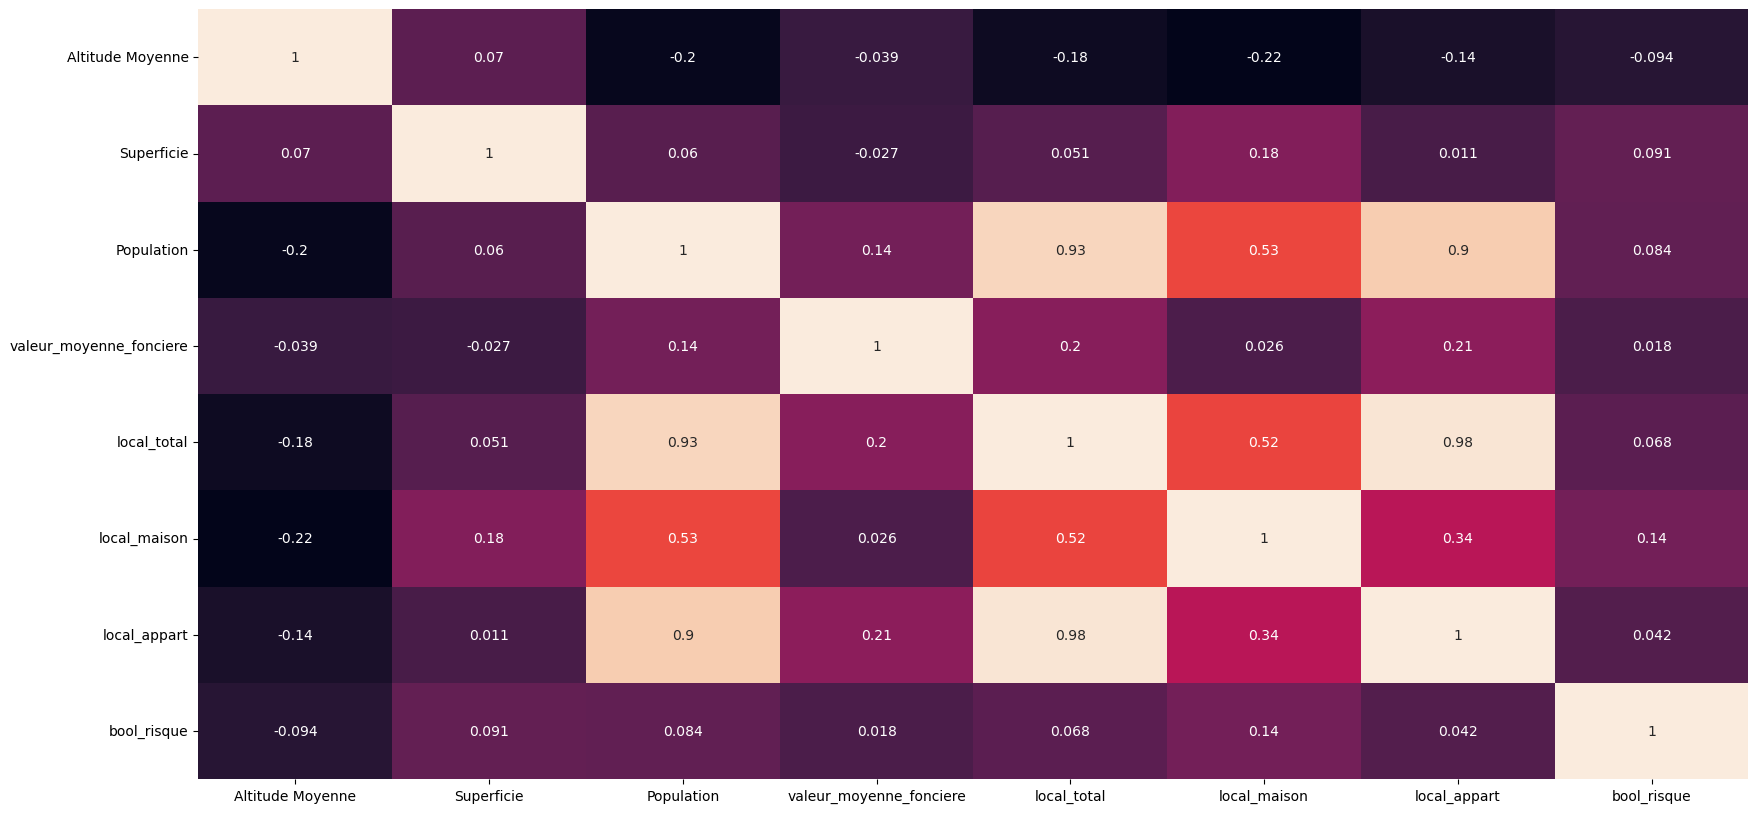

50 secondes


In [5]:
# corrélation

print(dfMergeFilter.columns)
#print(dfMergeFilter['Altitude Moyenne'].value_counts())
print(dfMergeFilter['Code Département'].value_counts())
print(dfMergeFilter['Code Région'].value_counts())
print(dfMergeFilter['num_risque'].value_counts())

dfMergeFilterCorr=dfMergeFilter[['Altitude Moyenne', 'Superficie', 'Population', 'Code Département', 'Code Région', 'valeur_moyenne_fonciere', 'local_total', 'local_maison', 'local_appart', 'num_risque']].copy()
#print(type(dfMergeFilterCorr))
dfMergeFilterCorr['bool_risque'] = dfMergeFilterCorr['num_risque'].apply(lambda x: 0 if x == '' else 1).copy()
print('bool_risque',dfMergeFilterCorr['bool_risque'].value_counts())
print(dfMergeFilterCorr['Code Département'].value_counts())
print(dfMergeFilterCorr['Code Région'].value_counts())
print(dfMergeFilterCorr['bool_risque'].value_counts())


plt.figure(figsize=(20, 10))
sns.heatmap(dfMergeFilterCorr.corr(), annot=True, cbar=False)
plt.show()


fin = time.time()
print('{:.0f}'.format(fin-debut), 'secondes')

# <span style='color:blue'>4. Conclusion</span>

La corrélation entre la valeur foncière et le risque d'inondation n'est pas évidente à déceler à ce niveau de précision. Le passage à un niveau de granularité plus important que le code Insee peut être judicieux pour démontrer cette relation. Une des pistes serait d'aller au niveau de la parcelle que donne le fichier immo.
https://www.geoportail.gouv.fr/donnees/parcelles-cadastrales